<h1> Deep Learning Small Project </h1>

In [1]:
%matplotlib inline

# Display
from IPython.display import Image

# Torch
import torch
from torch.utils.data import DataLoader
from torch import optim, nn

# Custom
import data
import model
import utils

Using Custom Dataloader, Data Split for First Layer classification task (normal vs infected)

In [2]:
fl_labels = {
0 : "Normal",
1 : "Infected"
}

fl_train = data.Lung_Dataset('train', verbose = 0)
fl_test = data.Lung_Dataset('test', verbose = 0)
fl_val = data.Lung_Dataset('val', verbose = 0)

"""
Data Split for Second Layer classification task (COVID vs Non-COVID) 
"""

sl_labels = {
0 : "COVID",
1 : "Non-COVID"
}

sl_train = data.Lung_Dataset('train', verbose = 2)
sl_test = data.Lung_Dataset('test', verbose = 2)
sl_val = data.Lung_Dataset('val', verbose = 2)

"""
Data Split for combined classification task (normal vs COVID vs Non-COVID) 
"""

combined_labels = {
0 : "Normal",
1 : "COVID",
2 : "Non-COVID"
}

final_val = data.Lung_Dataset('val', verbose = 1)
final_test = data.Lung_Dataset('test', verbose = 1)

Defining Model Parameters

In [3]:
N_EPOCH = 200
L_RATE = 0.001
BATCH_SIZE = 16
PATIENCE = 5
DROPOUT = 0.1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Training the First Layer Model

In [4]:
#First Model Training
fl_train_loader = DataLoader(fl_train, batch_size=BATCH_SIZE, shuffle=True)
fl_val_loader = DataLoader(fl_val, batch_size=BATCH_SIZE, shuffle=True)
fl_test_loader = DataLoader(fl_test, batch_size=BATCH_SIZE, shuffle=True)
    
fl_model = model.CNN(dropout=DROPOUT).to(device)
fl_optimizer = optim.AdamW(fl_model.parameters(), lr=L_RATE)
    
print("Training the first model to classify normal and infected images")
model.train(fl_model, device, nn.BCELoss(), fl_optimizer, fl_train_loader, fl_val_loader, N_EPOCH, PATIENCE, "fl")

print("\n\n")
print("Test Accuracy of the first model:")
model.test(fl_model, device, fl_test_loader)

fl_model.to("cpu")
    
model.save_model(fl_model, fl_optimizer, './saved_models/fl_model.pth')

Training the Second Layer Model

In [5]:
#Second Model Training
sl_train_loader = DataLoader(sl_train, batch_size=BATCH_SIZE, shuffle=True)
sl_val_loader = DataLoader(sl_val, batch_size=BATCH_SIZE, shuffle=True)
sl_test_loader = DataLoader(sl_test, batch_size=BATCH_SIZE, shuffle=True)
    
sl_model = model.CNN(dropout=DROPOUT).to(device)  
sl_optimizer = optim.Adam(sl_model.parameters(), lr=L_RATE)
    
print("\n\n")
print("Training the second model to classify COVID and non-COVID images")
model.train(sl_model, device, nn.BCELoss(), sl_optimizer, sl_train_loader, sl_val_loader, N_EPOCH, PATIENCE, "sl")
    
print("\n\n")
print("Test Accuracy of the second model:")
model.test(sl_model, device, sl_test_loader)
    
sl_model.to("cpu")
    
model.save_model(sl_model, sl_optimizer, './saved_models/sl_model.pth')

Analyzing the performance of each model (first layer and second layer models) 

Learning Curve of the First Layer Model

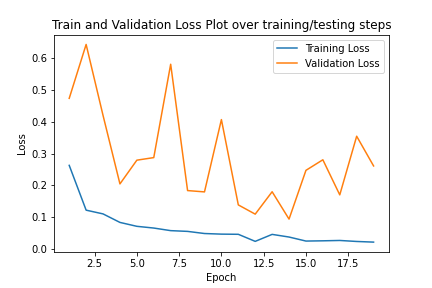

In [6]:
Image(filename='./saved_graphs/fl_learning_curve.png') 

Learning Curve of the Second Layer Model

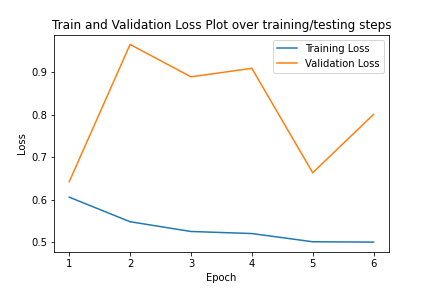

In [7]:
Image(filename='./saved_graphs/sl_learning_curve.png') 

Combine the 2 Models and Test the results on validation and test

0.5600000023841858
[1.0, 0.375, 0.4]
[0.875, 0.3333333333333333, 0.5]



Visualizing the Validation Set: 


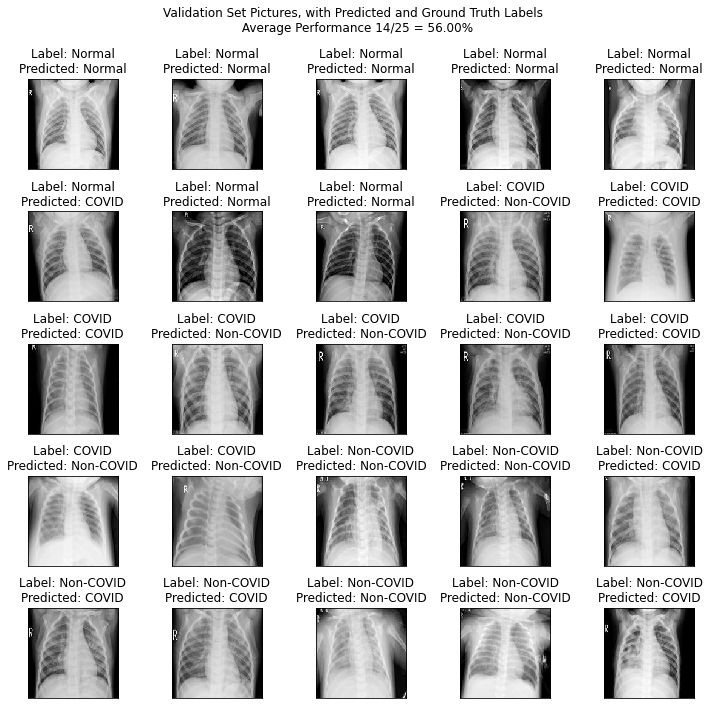

In [8]:
final_val_loader = DataLoader(final_val, batch_size=BATCH_SIZE, shuffle=False)
final_test_loader = DataLoader(final_test, batch_size=BATCH_SIZE, shuffle=True)
    
combined_model = model.load_combined('./saved_models/fl_model.pth','./saved_models/sl_model.pth',optim.AdamW ,L_RATE, DROPOUT)
pred = combined_model.predict_loader(device, final_val_loader)
actual = torch.empty(0, 3).to(device)
for _, labels in final_val_loader:
    labels = labels.to(device)
    actual = torch.cat((actual, labels), 0)

print(model.accuracy(pred, actual))
print(model.precision(pred, actual))
print(model.recall(pred, actual))
print("\n\n")
print("Visualizing the Validation Set: ")
utils.generate_performance_display(final_val_loader, pred, combined_labels)